In [23]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
from scipy.stats import pearsonr
from flopy.utils.sfroutputfile import SfrFile

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

def NSE(predictions,targets):
    mse = np.mean((predictions - targets) ** 2)
    nse = 1 - (mse / np.var(targets))
    return nse

def KGE(pred,obs):
    corr,_ = pearsonr(pred,obs)
    kge = 1- np.sqrt((np.std(pred)/np.std(obs) - 1)**2 + (np.mean(pred)/np.mean(obs) - 1)**2 +(corr- 1)**2)
    return kge



modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput/transientSeasons"

In [2]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio']#, 'Qout']

# load dataset
#data = np.loadtxt("ModflowSfrOutputTrans750.txt")
#data = np.loadtxt("Structure Changes/ModflowSfrAlluviumOutput1000.txt")
outputdf = pd.read_csv('TransSeasonsOutputStpTest.csv') #output
sampling = np.loadtxt("ModflowParams7-750Test12.txt")
#n = np.loadtxt('TransSamples.txt').astype('int')
pardf = pd.DataFrame(sampling, columns = col_names)

outputdf = outputdf[['simnum','Qout','reach','Stp']].reset_index() #only keep the cols we need
numTS = 6 #number of time steps to keep from the end
stps = 41 - numTS
outputdf = outputdf[outputdf['Stp'] > stps].set_index('simnum') #grab data from the last 5 stress periods and set index to simulation
simindex = outputdf.index.unique()
timestepidx = outputdf['index'].unique()
pardf = pardf.iloc[simindex]

print(len(timestepidx))
print(outputdf[outputdf['reach'] == 25])
print(pardf.reset_index(drop=True))

126000
         index     Qout  reach  Stp
simnum                             
1         1774  200.570     25   36
1         1824  189.880     25   37
1         1874  200.340     25   38
1         1924  189.660     25   39
1         1974  200.120     25   40
...        ...      ...    ...  ...
749     860774   39.760     25   37
749     860824   40.156     25   38
749     860874   39.742     25   39
749     860924   40.138     25   40
749     860974   39.725     25   41

[2520 rows x 4 columns]
            K  Low_K_ratio        Sy      Rech  ET_valley  ET_rip_ratio  \
0    0.252596     0.000074  0.058034  0.000203   0.000009      3.185117   
1    0.425213     0.761486  0.108251  0.000293   0.000002      2.180845   
2    0.258080     0.028534  0.218521  0.000174   0.000007      3.005435   
3    0.447384     0.002679  0.071039  0.000184   0.000006      1.934646   
4    0.347367     0.000020  0.239157  0.000223   0.000001      3.860679   
..        ...          ...       ...       ...    

# Decision Tree Code
Most of below is from:https://www.datacamp.com/community/tutorials/decision-tree-classification-python

RMSE:  41.42540498720835
Average NSE:  0.8306487804929878
Tree Depth:  4
Stress Period 30 NSE:  0.8346552359690859
Stress Period 31 NSE:  0.8305810304895951
Stress Period 32 NSE:  0.8338848946550899
Stress Period 33 NSE:  0.8296760456351597
Stress Period 34 NSE:  0.8330819915725336
Stress Period 35 NSE:  0.8287540598391865
Stress Period 36 NSE:  0.8322560098782452
Stress Period 37 NSE:  0.8278153505690333
Stress Period 38 NSE:  0.8314085855210971
Stress Period 39 NSE:  0.8268426777293976
Stress Period 40 NSE:  0.8305095610757831
Stress Period 41 NSE:  0.8258494891980727
Average KGE:  0.8238267054446542
Plot showing just simulaions with Q > 0


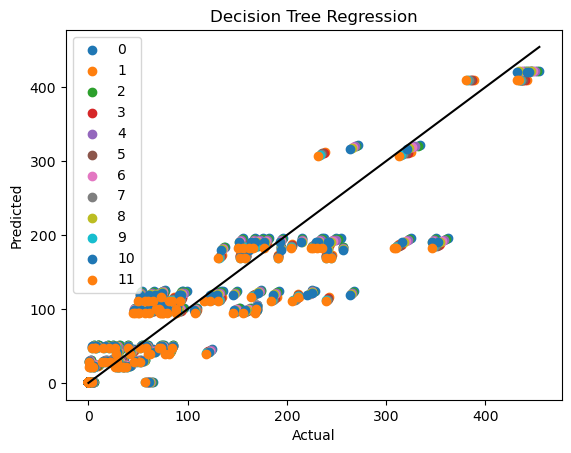

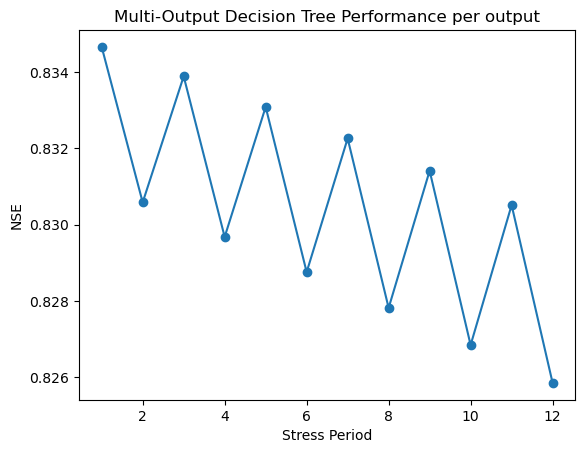

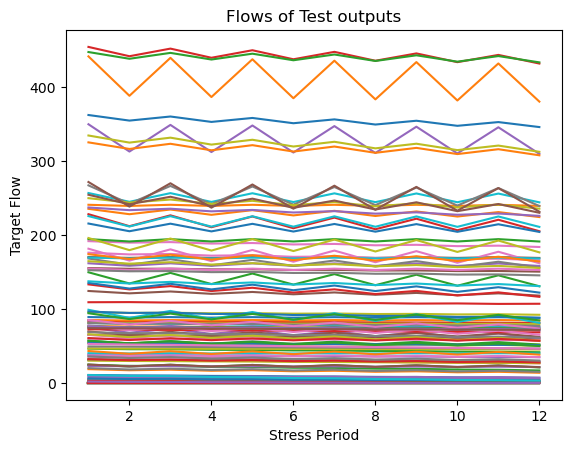

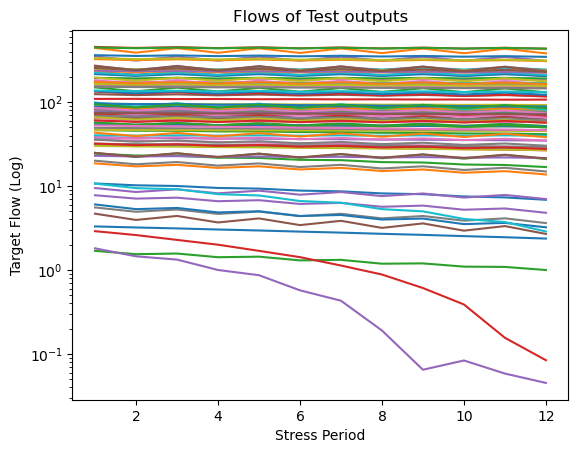

In [9]:
# Split dataset into training set and test set, default here is 30% test
rn  = 25 #reach number
outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this
#print(outputs)

X_train, X_test, y_train, y_test = train_test_split(pardf, outputs, test_size=0.3, random_state=0)

# Create Decision Tree classifer object
clf = DecisionTreeRegressor(
   # random_state = 0
    max_depth = 4

)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", NSE(y_pred, y_test))
#print("KGE: ", KGE(y_pred, y_test))
# print("Corr:",pearsonr(y_pred, y_test))
print("Tree Depth: ", clf.get_depth())

nselist = []
kgelist = []
for i in range(numTS):
    nselist.append(NSE(y_pred[:,i], y_test[:,i]))
    kgelist.append(KGE(y_pred[:,i], y_test[:,i]))

  #  print("Corr:",pearsonr(y_pred[:,i], y_test[:,i])) 
    print("Stress Period " +str(41 - (numTS-i)+1)+ " NSE: ", nselist[i])
    #print("Stress Period " +str(41 - (numTS-i)+1)+ " KGE: ", kgelist[i])
    
print("Average KGE: ", np.mean(kgelist))

print('Plot showing just simulaions with Q > 0')
# Plot the results
plt.figure()
for i in range(numTS):
    plt.scatter(y_test[:,i], y_pred[:,i], label = i)
outmax = np.max(outputs)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

plt.scatter(range(1,numTS+1),nselist)
plt.plot(range(1,numTS+1),nselist)
plt.xlabel("Stress Period")
plt.ylabel("NSE")
plt.title("Multi-Output Decision Tree Performance per output")
#plt.legend()
plt.show()

for i in range(len(y_test)):
    plt.plot(range(1,numTS+1),y_test[i])
plt.xlabel("Stress Period")
plt.ylabel("Target Flow")
plt.title("Flows of Test outputs")
#plt.yscale('log')
#plt.legend()
plt.show()
#plot for each stress period

for i in range(len(y_test)):
    plt.plot(range(1,numTS+1),y_test[i])
plt.xlabel("Stress Period")
plt.ylabel("Target Flow (Log)")
plt.title("Flows of Test outputs")
plt.yscale('log')
#plt.legend()
plt.show()
#plot for each stress period

[0.40875907 0.         0.         0.42892435 0.         0.
 0.16231657]
Feature: 0, Score: 0.40876
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.42892
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.16232


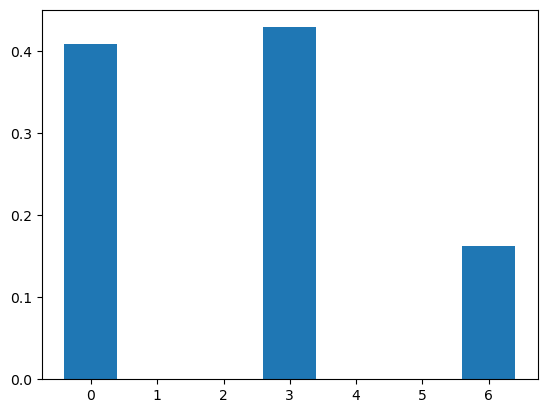

<Axes: >

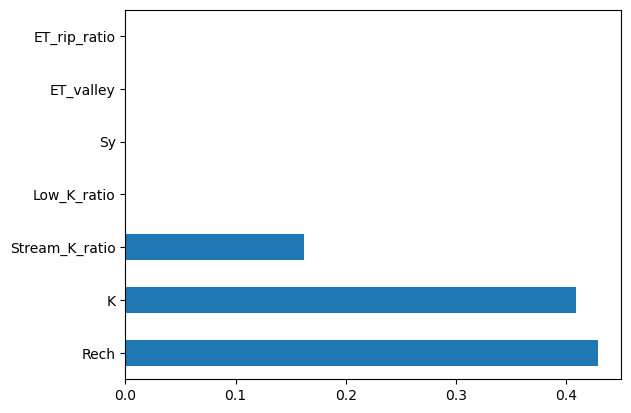

In [10]:
#feature importance
importance = clf.feature_importances_
print(importance)
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

feat_importances = pd.Series(clf.feature_importances_, index=pardf.columns)
feat_importances.nlargest(20).plot(kind='barh')

Reach 1 NSE:  nan
Reach 2 NSE:  0.9183442318338955
Reach 3 NSE:  0.9118075886923801
Reach 4 NSE:  0.9142157992525104
Reach 5 NSE:  0.9236596707107496
Reach 6 NSE:  0.8678832811662215
Reach 7 NSE:  0.9088893730150855
Reach 8 NSE:  0.8637402015989778
Reach 9 NSE:  0.8839287866890269
Reach 10 NSE:  0.8635061675377336
Reach 11 NSE:  0.8557306909327904
Reach 12 NSE:  0.8910048382912105
Reach 13 NSE:  0.882246596685217
Reach 14 NSE:  0.8588326095171614
Reach 15 NSE:  0.8586863352311962
Reach 16 NSE:  0.8671302357568113
Reach 17 NSE:  0.8850304623047157
Reach 18 NSE:  0.8850709515038622
Reach 19 NSE:  0.8809235693058278
Reach 20 NSE:  0.8819092920617063
Reach 21 NSE:  0.879691303082074
Reach 22 NSE:  0.8739283208642223
Reach 23 NSE:  0.9021688719426996
Reach 24 NSE:  0.9157842837595226
Reach 25 NSE:  0.8820382052676964
Reach 26 NSE:  0.8892836342540661
Reach 27 NSE:  0.8969311253513885
Reach 28 NSE:  0.833703085008143
Reach 29 NSE:  0.7992653409174035
Reach 30 NSE:  0.8054627067011975
Reach 3

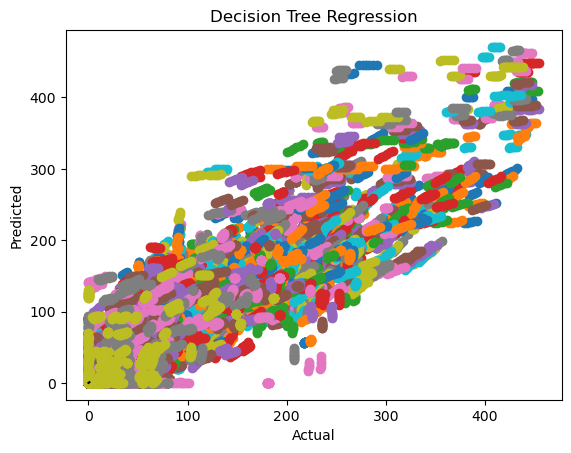

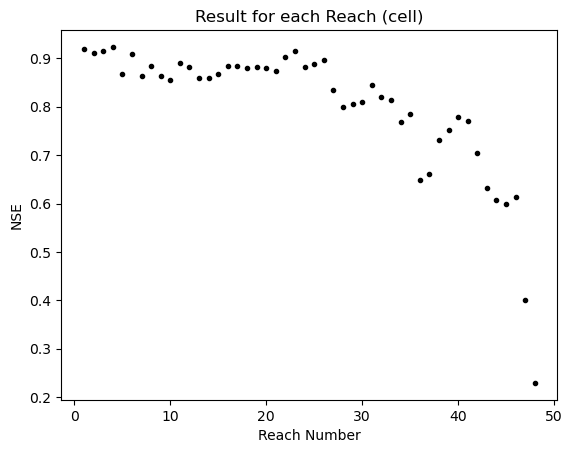

In [11]:
#try to predict Qout with parameters at every reach
reachnum = 50
Reach_importance = []
nse_list = []
simnum = []

for i in range(1,reachnum):
    
    Y3 = np.asarray(outputdf[outputdf['reach'] == i]['Qout']).reshape((len(simindex),numTS))#[:,1] #probably a better way to do this

    X3 = pardf
    
   # numgrz = np.where(Y3 > 0) 
   # print('Number of simulations > 0 : ' + str(numgrz))
    
    # Split dataset into training set and test set, default here is 30% test
    X_train, X_test, y_train, y_test = train_test_split(X3, Y3, test_size=0.3, random_state=0)

    # Create Decision Tree classifer object
    reachTree = DecisionTreeRegressor(
        #random_state = 0
         #max_depth = 9
    )

    # Train Decision Tree Classifer
    reachTree = reachTree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = reachTree.predict(X_test)

    #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#     print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#     print("NSE: ", NSE(y_test, y_pred))
#     print("Tree Depth: ", reachTree.get_depth())
    #print("Reach "+str(i)+" RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
    print("Reach "+str(i) + " NSE: ", NSE(y_pred, y_test))
    nse_list.append(NSE(y_pred, y_test))
   # simnum.append(numgrz)
    # Plot the results
    #plt.figure()
    label = "Reach " + str(i)
    plt.scatter(y_test, y_pred, label = label)  

   #plt.legend()


    #feature importance
    importance = reachTree.feature_importances_
    Reach_importance.append(importance)

#outmax = np.max(ReachQ)
outmax = 1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
#plt.legend()
plt.show()

plt.plot(nse_list, 'k.')

plt.xlabel("Reach Number")
plt.ylabel("NSE")
plt.title("Result for each Reach (cell)")
plt.show()


# plt.plot(simnum)

# plt.xlabel("Reach Number")
# plt.ylabel("Number of Simulations with Q > 0")
# plt.title("Number of non-dry simulations for each Reach (cell)")
# plt.show()

## Now for the Wells

In [5]:
#all_well_loc = np.array(np.meshgrid(np.arange(50),np.arange(50))).T.reshape(-1,2)
#print(all_well_loc)

#load in Ibound and find active cells in model - then put it into a list of well locations
ibound = np.loadtxt('ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T



In [6]:
# #Cell block for test head object out put - can ignore 

# modelname = "ScenarioSfr750Seasons_"+str(simindex[0])
# headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
# head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
# print(head.shape)
# print(head[::30,21,32][-6:])
# headtimes = np.array(headobj.get_times())
# print(headtimes)

# print(headtimes[::30])
# print(len(headtimes[::30]))

# headts = headobj.get_ts([(0,21,32)])
# #headts[10:,0] = (headts[10:,0] / 6) * 50  *2
# print(headts[::30][-numTS:].astype('int'))
# print(headobj.get_ts([(0,21,32)])[::30,1][-numTS:].astype('int'))


# print(len(headts))
# headstp = np.divmod(np.arange(len(headts)-10),30*2)[0]+1

# plt.plot(headts[::30,1])
# plt.show()
# plt.plot(headts[:,1])

In [9]:
#Get Head data for All active wells
import seaborn as sns
sns.set_style("white")
#numTS = 6
well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_error_sim = []
#well_error_num = []

for j, i in enumerate(simindex):
    modelname = "ScenarioSfr750SeasonsTest_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#     for k in range(all_well_loc.shape[0]):
#         well_head[k][j][:] = headobj.get_ts([(0,int(all_well_loc[k][0]),int(all_well_loc[k][1]))])[::30,1][-numTS:] #complicated way of getting all the heads (numTS) by sampling every 30 of the head ts foreach well
#         if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
#                 well_error_sim.append(i)              
                
    head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
    for k in range(all_well_loc.shape[0]): #grabbing the last 2 timesteps - or tryting too
            well_head[k][j][:] = head[::30,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would 
           # well_head[k][j][1] = head[-1][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would  be 60
            if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
                well_error_sim.append(i)
print("Done")

Done


In [10]:
#new_zone.head
well_head_df = pd.DataFrame(well_head.transpose(1,0,2).reshape(len(simindex),well_head.shape[0]*numTS))#, index = pardf.index) #put the wwells into an unput that has each stress period so now input os 4024 long
print(well_head_df)
print(len(well_head_df.index))
well_head_df.to_csv('Well_head_seasons.csv')
well_head_df.to_pickle('Well_head_seasons.pkl')
               
#print(new_zone)

          0           1           2           3           4           5      \
0    100.947212  100.943222  100.939056  100.935188  100.931114  100.927330   
1     99.750465   99.712372   99.674309   99.636322   99.598457   99.560699   
2    100.362366  100.353127  100.343575  100.333717  100.323479  100.313087   
3     87.995018   87.948776   87.902641   87.856674   87.810844   87.765259   
4     97.486771   97.465065   97.439606   97.418259   97.393150   97.372131   
..          ...         ...         ...         ...         ...         ...   
415   93.388260   93.371178   93.332642   93.316154   93.278214   93.262276   
416   93.971336   93.966354   93.961098   93.955833   93.950363   93.945038   
417   87.831367   87.832436   87.833450   87.834412   87.835327   87.836212   
418  103.653870  103.654572  103.655258  103.655922  103.656525  103.657120   
419   98.082314   98.081413   98.080460   98.079529   98.078537   98.077621   

          6           7           8           9    

In [7]:

#Skip down to here to use the pickle of well heads that have already been pulled from the Modflow files

well_head_df= pd.read_pickle('Well_head_seasons.pkl')
well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
print(well_head_df.index)

#print(np.arange(all_well_loc.shape[0]).reshape((int(all_well_loc.shape[0]/numTS),numTS)))

RangeIndex(start=0, stop=420, step=1)


RMSE:  34.98847802818872
NSE:  0.8414328965987333


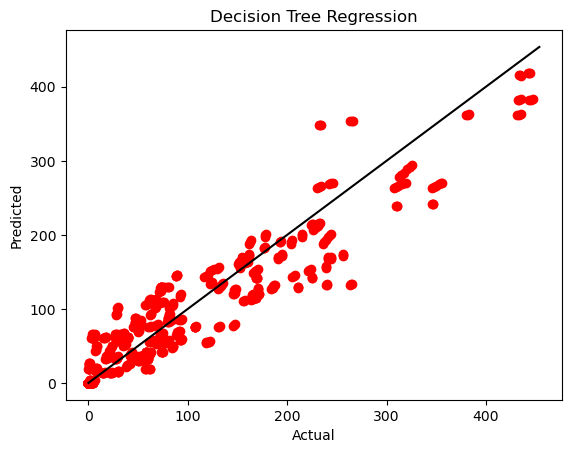

In [6]:
## Using only the new set of models in the test of predicting flow with parameters
#Split dataset into training set and test set, default here is 30% test
test = pardf.reset_index(drop=True).loc[well_head_df.index]
rn = 25
outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this


test_q = outputs[well_head_df.index]
#test_q = np.asarray(test_q[test_q['reach'] == 25]['Qout']).reshape((len(well_head_df.index),numTS))#[:,1] #probably a better way to do this


X_train, X_test, y_train, y_test = train_test_split(test, test_q, test_size=0.3, random_state=0)

# Create Decision Tree classifer object
clf = DecisionTreeRegressor(
    random_state = 0
    #max_depth = 2
)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_test, y_pred))
#print("Tree Depth: ", clf.get_depth())

# Plot the results
plt.figure()
plt.scatter(y_test, y_pred, color='r')
outmax = np.max(test_q)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [7]:
#Same analysis but for predicting head at each one of the wells using the parameters
t0 = time.time()

nse_list = []
well_importance = []
#well_head[zone.index]
well_heads_loc = np.arange(all_well_loc.shape[0]*numTS).reshape((int(all_well_loc.shape[0]),numTS)) #splits the well head_df into subsets aplicable to the location (so we ahve numTS outputs)

for i in well_heads_loc:
    
    # Split dataset into training set and test set, default here is 30% test
    X_train, X_test, y_train, y_test = train_test_split(test, well_head_df[i], test_size=0.3, random_state=1)
    # Create Decision Tree classifer object
    wellTree = DecisionTreeRegressor(
    #wellTree = RandomForestRegressor(
    #max_depth = 4
    )

    # Train Decision Tree Classifer
    wellTree = wellTree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = wellTree.predict(X_test)
  
    #nse_list.append(np.mean(NSE(y_pred, y_test).tolist())) #with multiple objectives we now have two values for y_pred and y_test so this will return NSE for each (right now we just average but could look at them individually)
    nse_list.append(NSE(y_pred, y_test)) #with multiple objectives we now have two values for y_pred and y_test so this will return NSE for each (right now we just average but could look at them individually)

    #print(NSE(y_pred, y_test).tolist())
    importance = wellTree.feature_importances_
    well_importance.append(importance)

t1 = time.time()

print('Time: ' + str(t1-t0))

Time: 35.525861978530884


In [8]:
#print(well_importance)
# #print(well_importance[3])
# for i in range(10):
#     plt.bar([x for x in range(len(well_importance[i]))], well_importance[i])
#     plt.show()

print(len(nse_list))
nse_all = np.reshape(nse_list,(2012,numTS))

2012


C:\Users\davem\AppData\Local\Temp\ipykernel_12848\4083020405.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


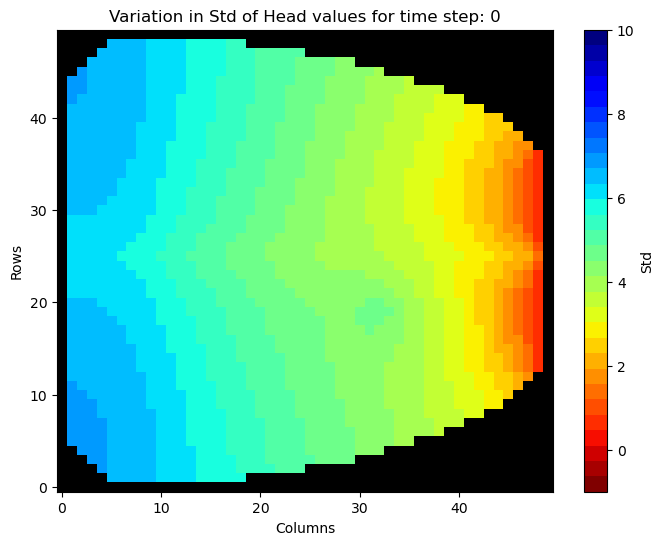

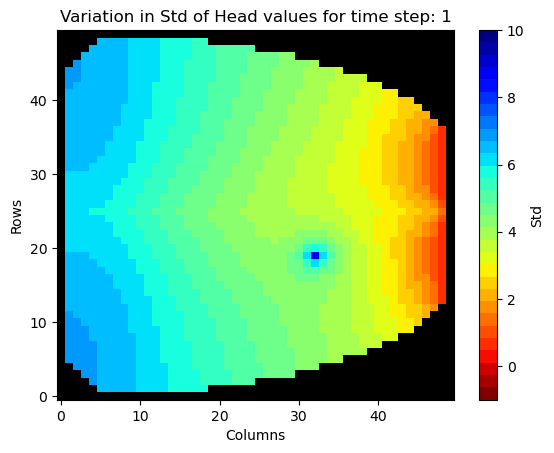

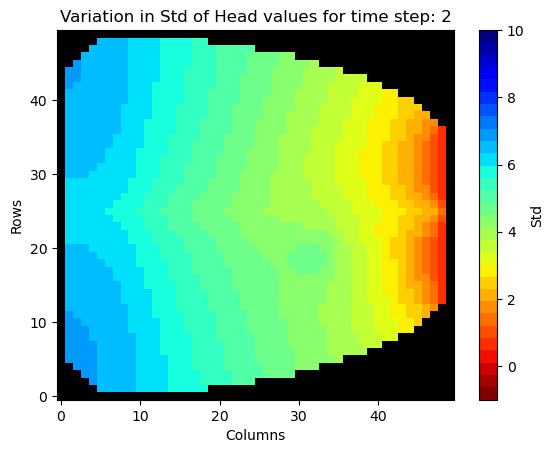

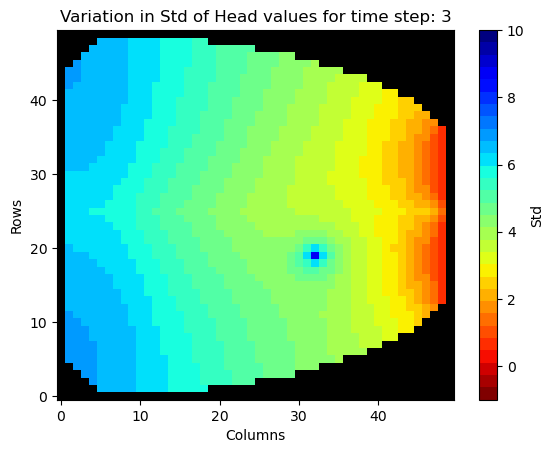

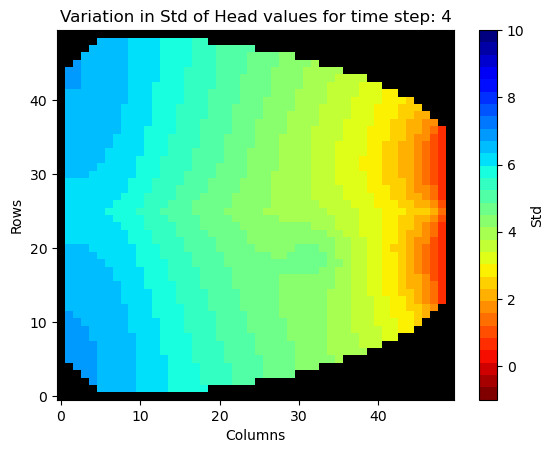

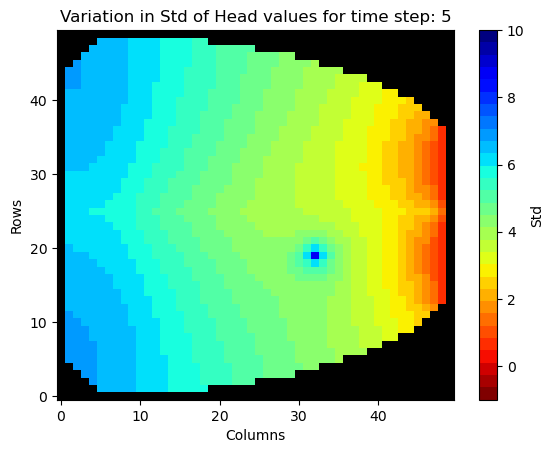

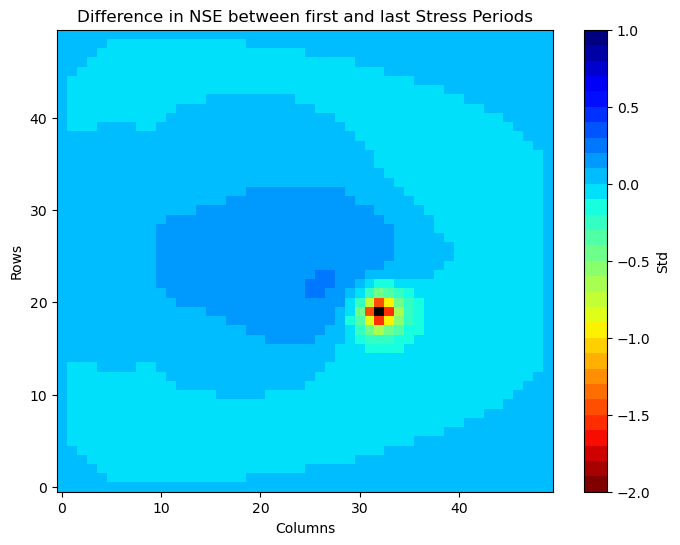

In [136]:



kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

test = well_head_df.to_numpy().reshape((len(simindex),well_head.shape[0],numTS))
#print(test)
# well_head_var = test.var(axis=(0,1))
# print(well_head_var.shape)
# #print(well_head_var)
well_head_var = np.empty((well_head.shape[0],numTS))

for i in range(well_head.shape[0]):
    for k in range(numTS):
        well_head_var[i][k] = np.std(test[:,i,k])
        
#print(well_head_var)
wellmesh = np.ndarray((numTS,50,50))
wellmesh[:][:][:] = -999

for i in range(all_well_loc.shape[0]):
    wellmesh[:,int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_var[i]

#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("k")


plt.figure(figsize=(8,6))

for i in range(numTS):
    plt.pcolormesh(KK,GG,wellmesh[i], vmax = 10,cmap = cmap2, vmin = -1,shading='nearest')
    plt.colorbar(label = 'Std')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Variation in Std of Head values for time step: ' + str(i))
    plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

#plt.imshow(wellmesh, cmap='RdBu')

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh[0] - wellmesh[-1], vmax = 1,cmap = cmap2, vmin = -2,shading='nearest')
plt.colorbar(label = 'Std')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Difference in NSE between first and last Stress Periods')
plt.show() 


C:\Users\davem\AppData\Local\Temp\ipykernel_12848\2759524653.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


Text(0.5, 1.0, 'Estimating the head at each cell using the Ensemble parameters with a Decision Tree')

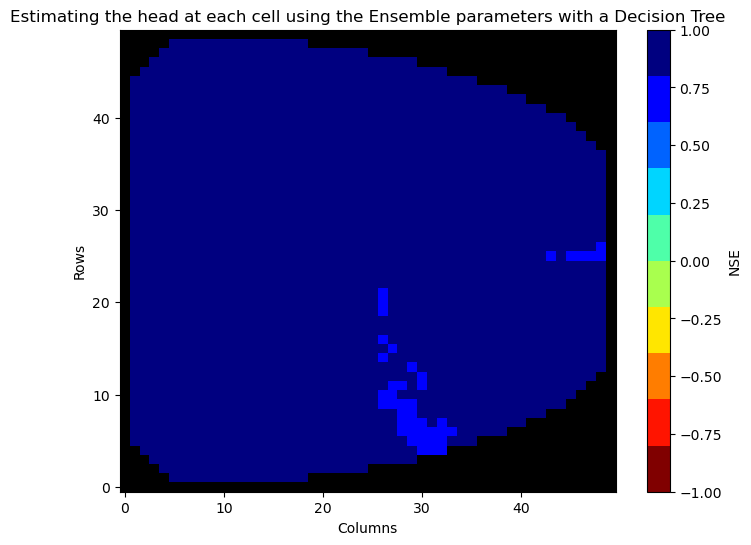

In [15]:
nse_list_remove = [-50 if (np.any(np.isinf(x)) or np.any(np.isnan(x))) else x for x in nse_list] #np.any only nessesay if pasing NSE for each stress period individually 
#s = np.isnan(nse_list_remove)
#print(len(nse_list_remove))
nse_list_remove = np.reshape(nse_list_remove,(len(nse_list_remove),numTS))
wellmesh = np.ndarray((numTS,50,50))
wellmesh[:] = -1e30

for k in range(numTS):
    for i in range(all_well_loc.shape[0]):
        wellmesh[k][int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = nse_list_remove[i][k]

#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=10)
cmap2.set_under("k")


plt.figure(figsize=(8,6))
for i in range(numTS):
    plt.pcolormesh(KK,GG,wellmesh[i], vmax = 1,cmap = cmap2, vmin = -1,shading='nearest')
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = 'NSE')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Estimating the head at each cell using the Ensemble parameters with a Decision Tree')

## Using Wells to predict stream Flow

In [8]:
# Since we changed the number of wells - use this for flow only outputs
#well_df = pd.DataFrame(new_well_head.transpose(), index = new_zone.index)

well_sample = well_head_df.sample(frac = 0.1, axis = 1)

river_well_loc = np.where(all_well_loc[:,0] == 25) #
#print(river_well_loc)
#print(len(all_well_loc))
CHBound_loc = np.where(all_well_loc[:,1] == 48) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)

drop_locs2 = drop_locs*numTS #for transient
for i in range(1,numTS):
    drop_locs2 = np.append(drop_locs2,(drop_locs2+i))#add the location of the ather stress period heads
    
print(drop_locs2)

#drop out the well heads 
well_head_noRiv = well_head_df.drop(drop_locs2, axis = 1)

print(well_head_df.shape)
outputs = np.asarray(outputdf['Qout']).reshape((len(simindex),numTS*50))#[:,1] #there is probably a better way to do this
print(outputs.shape)
#print(well_head_df)
#well_head_noRiv = well_head_noRiv.drop(CHBound_loc[0], axis = 1)
#print(well_head_noRiv.columns)

[6036 6042 6048 ... 8925 9213 9501]
(420, 12072)
(420, 300)


In [9]:
#Seems silly but need to convert the column names to strings otherwise it won't track the feature names
#This is not needed if every feature is used (likely in the ensemble methods), in the decision trees this might not be the case
well_head_noRiv.columns = well_head_noRiv.columns.astype(str)
well_head_noRiv.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '12062', '12063', '12064', '12065', '12066', '12067', '12068', '12069',
       '12070', '12071'],
      dtype='object', length=11416)

In [ ]:
#choosing one reach and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#only reach rn
rn = 25
#outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this

#Training on All reaches
outputs = np.asarray(outputdf['Qout']).reshape((len(simindex),numTS*50))#[:,1] #there is probably a better way to do this

#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2)

#split quality function
split_criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
#Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,11)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

splitter = ['best']
# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease,
                'splitter': splitter}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dtr = DecisionTreeRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dtr_random.fit(X_train, y_train)
best_pars = dtr_random.best_params_
print(best_pars)

from sklearn.tree import plot_tree


best_random = dtr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

# _, ax = plt.subplots(figsize=(25, 25))
# _ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

{'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_leaf_nodes': [21, 65, 109, 153, 197, 241, 285, 329, 373, 417, None], 'min_impurity_decrease': [5, 15, 25, 35, 45], 'splitter': ['best']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [10]:
#Use this to skip the hyperparameter selection above that takes a very long time 

best_pars = {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'min_impurity_decrease': 25, 'max_leaf_nodes': 21, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'friedman_mse'}

## Tree using Wells to predict Qout
### Using Hyperparameters from above

In [16]:
# Split dataset into training set and test set using 20%
t0 = time.time()
n = 100

PredList = []
NSEList = []
importanceList = []
importanceListAll = []
depthlist = []



rn = 25

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this
print(outputs.shape)
for i in range(n):
    #well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2)#, random_state=0) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object
    Tree = DecisionTreeRegressor(**best_pars)

    # Train Decision Tree Classifer
    Tree = Tree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = Tree.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    depthlist.append(Tree.get_depth())
  
    feat_df = pd.DataFrame(Tree.feature_importances_, index = Tree.feature_names_in_.astype('int')) 
    imp_df = imp_df.merge(feat_df.rename(columns={0:i}), left_index=True, right_index = True)

    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Median NSE: ", np.median(NSEList))
print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results




print('Total time: ' + str(time.time()-t0))




(420, 6)
Median NSE:  0.782967739847946
Average Tree Depth:  6.0
Total time: 59.04286766052246


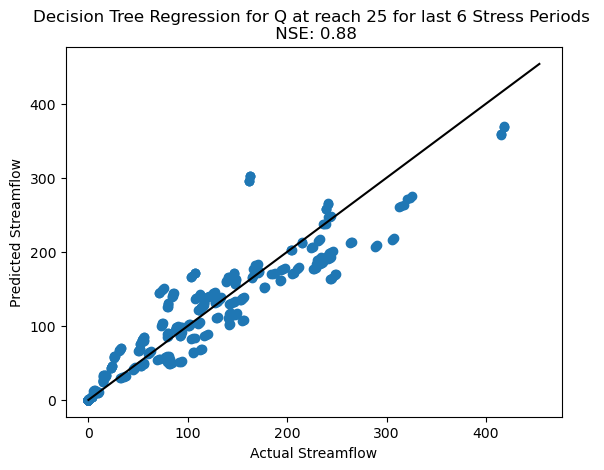

In [48]:
imp_df.to_pickle('Seasons_DT_Impdf.pkl')

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(outputs)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Regression for Q at reach " + str(rn) +" for last 6 Stress Periods \n NSE: " + str(round(np.median(NSEList),2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [20]:
#Testing out the feature importances - can pull it out by stress period but for some reason there's not an importance value for every feature...
#print(imp_df.sum(axis=1))
#usedFeatures = Tree.feature_names_in_.astype('int') #Get an array of features used in the decision tree as ints 
#feat_df = pd.DataFrame(Tree.feature_importances_, index = Tree.feature_names_in_.astype('int')) #make a dataframe of the feature importances with the index set to the feature name

total_imp_df = imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 

#Sum up all the stress periods for each well location
AllTSimp = total_imp_df.groupby(total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)
print((int(well_head_noRiv.columns[-1])+1 )/numTS)
print(total_imp_df.index[-1])
#featInTS = np.intersect1d(usedFeatures, featIndices+4)
print(total_imp_df.sum()) #should be 1
print(TSIndices)
for i in range(numTS):
    featInTS = np.intersect1d(total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(total_imp_df.loc[featInTS].sum()))
    
#Should probably use this now - it tracks the well location number with the index
well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])

#print(feat_df.idxmax()//numTS)
#print(total_imp_df.nlargest(10))

2012.0
12071
1.0
[    0     6    12 ... 12054 12060 12066]
[    0     6    12 ... 12054 12060 12066]
Number of Features used in Stress period 0: 1895
Sum of Importances in Stress period 0: 0.1327368392335626
[    1     7    13 ... 12055 12061 12067]
Number of Features used in Stress period 1: 1895
Sum of Importances in Stress period 1: 0.14493087401199078
[    2     8    14 ... 12056 12062 12068]
Number of Features used in Stress period 2: 1895
Sum of Importances in Stress period 2: 0.18457601490327882
[    3     9    15 ... 12057 12063 12069]
Number of Features used in Stress period 3: 1895
Sum of Importances in Stress period 3: 0.18205424154001976
[    4    10    16 ... 12058 12064 12070]
Number of Features used in Stress period 4: 1918
Sum of Importances in Stress period 4: 0.15303114149557748
[    5    11    17 ... 12059 12065 12071]
Number of Features used in Stress period 5: 1918
Sum of Importances in Stress period 5: 0.20267088881557052


In [26]:
#feature importance Mapping

importance_df = pd.DataFrame(importanceList).sum()


wellmesh_dt = np.ndarray((50,50))
wellmesh_dt[:,:] = -1e30
all_well_locNoRiv = np.delete(all_well_loc, drop_locs, axis = 0)
#for i in range(all_well_loc.shape[0]):
# for i in range(len(importance_df.index)):
#     #if(all_well_loc[i,1] != 25):
#     wellmesh[int(all_well_locNoRiv[i, 1]), int(all_well_locNoRiv[i, 0])] = importance_df[i] #np.sum(importanceList[:,i])  

#featIndices = np.arange(0,len(importanceListAll[0]),numTS)
for k in AllTSimp.index:
        wellmesh_dt[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = AllTSimp.loc[k]
        
wellmesh_AllTs = np.ndarray((numTS,50,50))
wellmesh_AllTs[:,:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs, axis = 0)
#for i in range(all_well_loc.shape[0]):

#featInTS = np.intersect1d(usedFeatures, featIndices)
#pd.DataFrame(importanceArr[featInTS])#just going to use step period 0
for i in range(numTS):
    featInTS = np.intersect1d(total_imp_df.index, TSIndices+i)    
    for k in featInTS:
        wellnum = k // numTS
        wellmesh_AllTs[i,int(well_loc_df.loc[wellnum, 1]), int(well_loc_df.loc[wellnum, 0])] = total_imp_df.loc[k] #np.sum(importanceList[:,i]) 
    

C:\Users\davem\AppData\Local\Temp\ipykernel_8540\3222872415.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


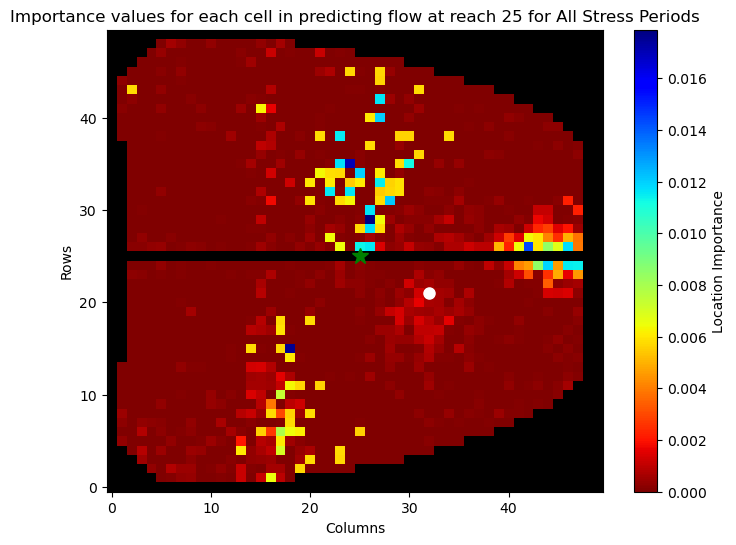

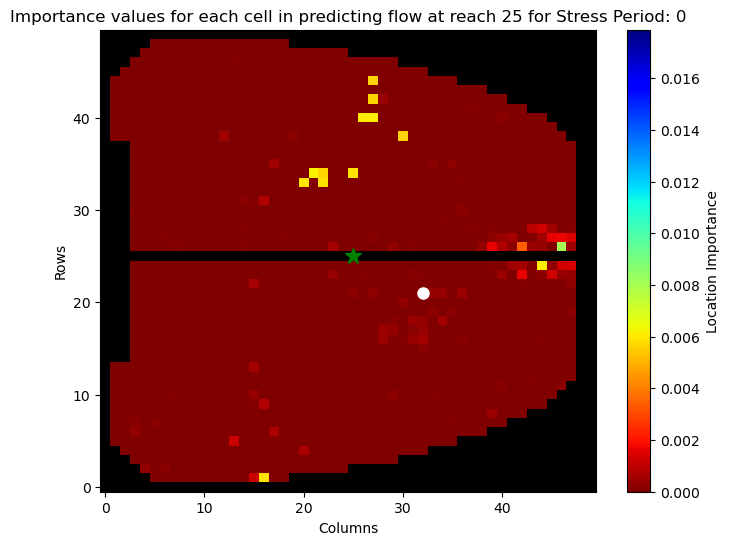

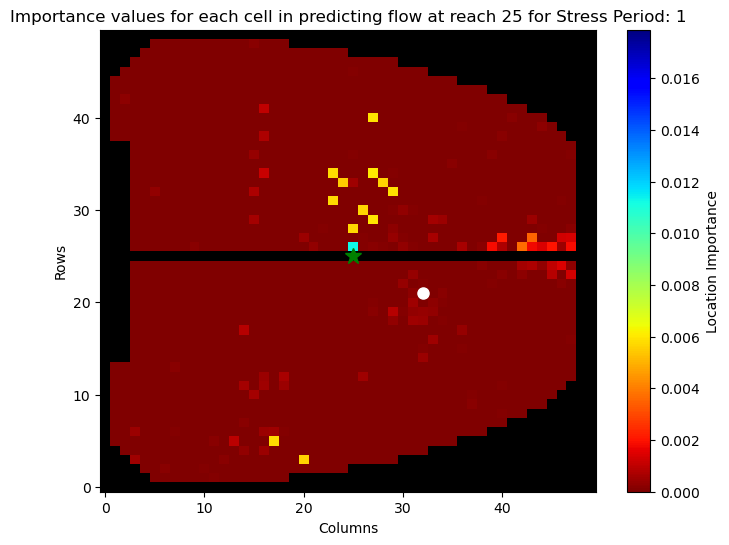

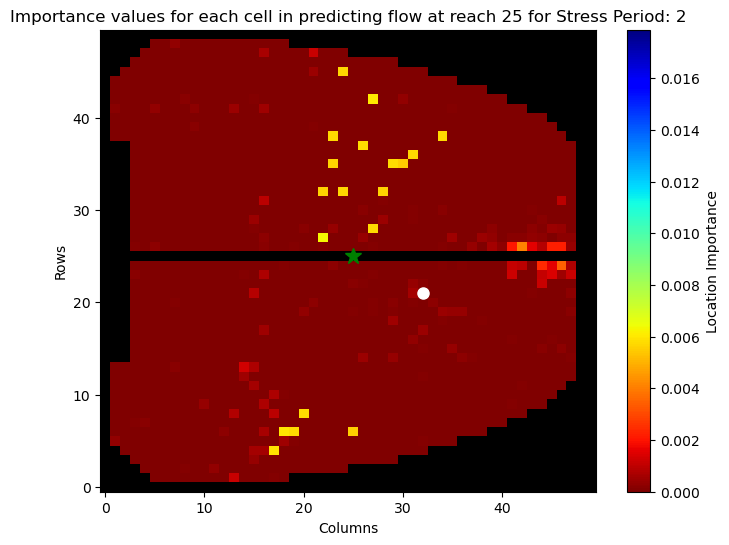

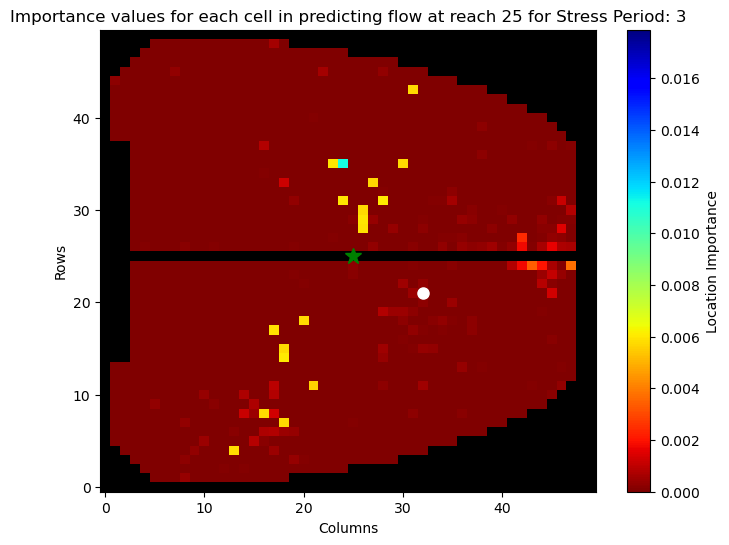

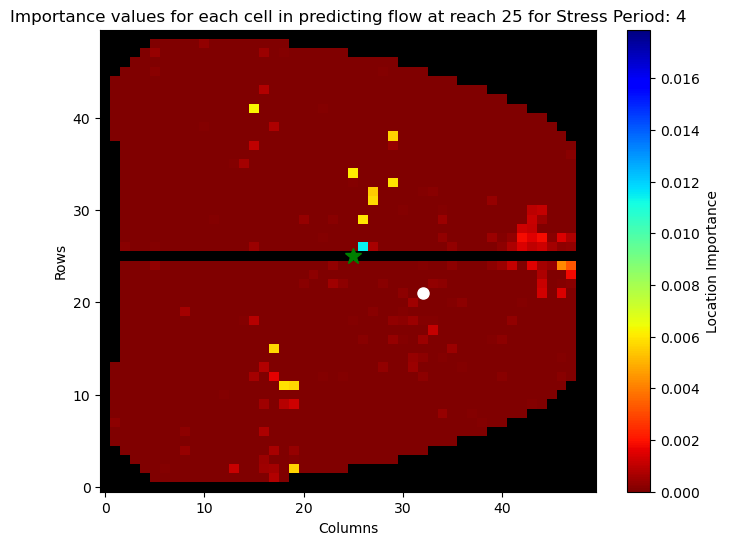

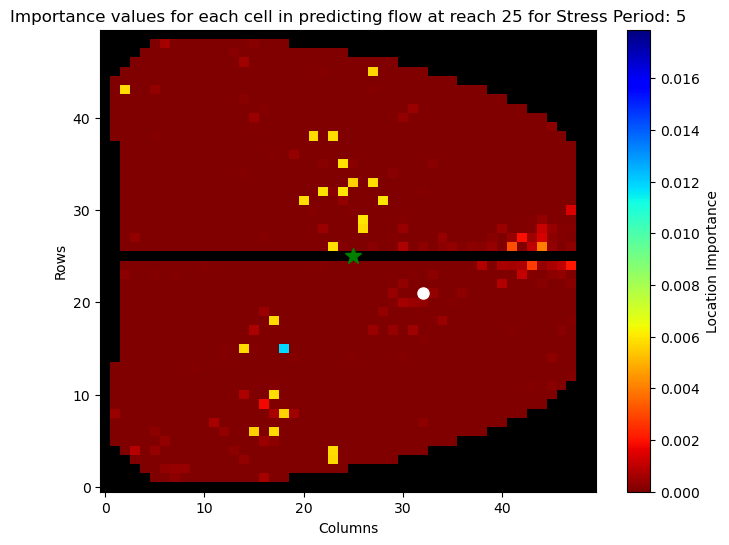

In [27]:
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(AllTSimp)
#vmax = 1
vmin = np.min(AllTSimp)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_dt,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Importance values for each cell in predicting flow at reach ' + str(rn)+' for All Stress Periods')


for i in range(numTS):
    plt.figure(figsize=(8,6))
    plt.pcolormesh(KK,GG,wellmesh_AllTs[i],vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
    plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
    plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
    # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
    #plt.show()
    #plt.imshow(wellmesh, cmap='RdBu')
    plt.colorbar(label = "Location Importance")
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Importance values for each cell in predicting flow at reach ' + str(rn)+' for Stress Period: ' +str(i))


In [49]:
# mostImportant = importance_df[importance_df > 0.1]
# print(len(mostImportant.index))

# print(np.max(mostImportant))

In [50]:
# # Split dataset into training set and test set, default here is 30% test
# t0 = time.time()
# n = 100

# PredList = []
# NSEList = []
# importanceList = []

# #new_zone_q = ReachQdf.loc[well_head_noRiv.index]
# mostImpWellHead = well_head_df.loc[:,mostImportant.index]

# for i in range(n):
#     well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
#     X_train, X_test, y_train, y_test = train_test_split(mostImpWellHead, new_zone_q[30], test_size=0.3, random_state=0)
#     # Create Random Forest Object
#     Tree = DecisionTreeRegressor(
#     #max_depth = 2 {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
#     )

#     # Train Decision Tree Classifer
#     Tree = Tree.fit(X_train,y_train)

#     #Predict the response for test dataset
#     y_pred = Tree.predict(X_test)
#     PredList.append(y_pred)
#     NSEList.append(NSE(y_pred, y_test))
#     #feature importance
#     importanceList.append(Tree.feature_importances_)
   
    
    
# #well head Tree NSE
  
# #print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
# print("Average NSE: ", np.mean(NSEList))

# t1 = time.time()

# total = t1-t0
# print('Total time: ' + str(total))

In [242]:
# print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))

# WellStreamimportance = Tree.feature_importances_

# miimportance_df = pd.DataFrame(importanceList).sum()

# plt.plot(miimportance_df, '.k')

In [31]:
# #feature importance Mapping
# miwellmesh = np.ndarray((50,50))
# miwellmesh[:,:] = -1e30
# #all_well_locNoRiv = np.delete(all_well_loc, river_well_loc[0], axis = 0)
# #for i in range(all_well_loc.shape[0]):
# for i,k in enumerate(mostImportant.index):
#     #if(all_well_loc[i,1] != 25):
#     miwellmesh[int(all_well_locNoRiv[k, 1]), int(all_well_locNoRiv[k, 0])] = miimportance_df[i] #np.sum(importanceList[:,i])  


In [241]:
# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# #PLotting out the result grid

# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(miimportance_df)
# #vmax = 1
# vmin = np.min(miimportance_df)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,miwellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Importance values')


In [178]:
# result = permutation_importance(
#     Tree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )

In [240]:
# print(result.importances_mean)

# wellmesh = np.ndarray((50,50))
# wellmesh[:,:] = -1e30

# for i in range(all_well_loc.shape[0]):
#     wellmesh[int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = result.importances_mean[i] #np.sum(importanceList[:,i])

# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(0.001)
# vmin = np.min(WellStreamimportance)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Permutation Importance values')

## Gradient Boosting

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
{'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10, 25], 'min_samples_leaf': [1, 2, 4], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'subsample': 0.5, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease

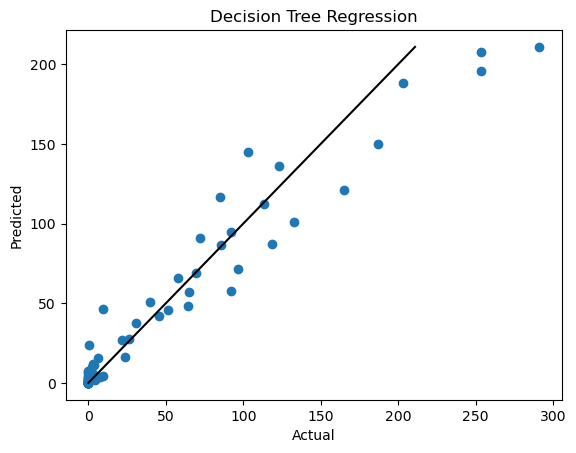

In [19]:
#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

print(GradientBoostingRegressor().get_params().keys())

#rn = 25
#outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this
#All reaches
outputs = np.asarray(outputdf['Qout']).reshape((len(simindex),numTS*50))#[:,1] #there is probably a better way to do this

#print(rand_well)
#Randomized cv search only works with a single output when using gradient boosting regressor, apparently, so using the last stress period data
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs[:,-1], test_size=0.2) 
#X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[32], test_size=0.2)
loss = ['squared_error', 'absolute_error', 'huber', 'quantile']
n_estimators = [int(x) for x in range(25,275,50)]
subsample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
splitter = ['best']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'loss' : loss,
                'subsample':subsample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgr_random = RandomizedSearchCV(estimator = xgr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgr_random.fit(X_train, y_train)# error_score='raise')
best_pars_gr = xgr_random.best_params_
print(best_pars_gr)

#from sklearn.tree import plot_tree


best_random_gr = xgr_random.best_estimator_
y_pred = best_random_gr.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

In [28]:
best_pars_gr = {'subsample': 0.5, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'huber', 'criterion': 'friedman_mse'}

Average NSE:  0.9159969727120079
Total time: 7.558936595916748


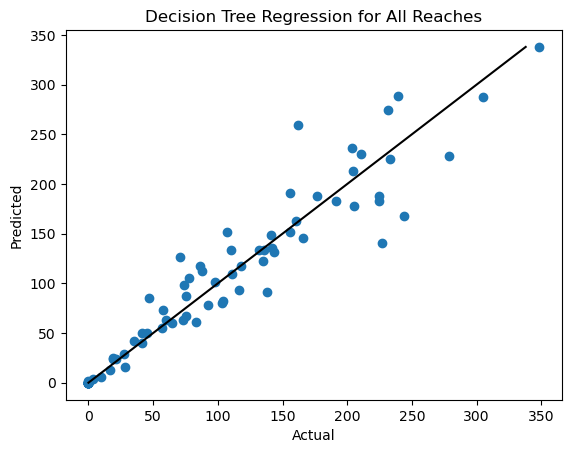

In [32]:
#Gradient Boosting-  Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
importanceList_gr = []
importanceListAll_gr = []
depthlist = []

gr_imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

rn = 25

for i in range(n):
   # well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs[:,-1], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
    GradBoost = GradientBoostingRegressor(**best_pars_gr)
    
    GradBoost = GradBoost.fit(X_train,y_train)
    y_pred = GradBoost.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))

    gr_feat_df = pd.DataFrame(GradBoost.feature_importances_, index = GradBoost.feature_names_in_.astype('int')) 
    gr_imp_df = gr_imp_df.merge(gr_feat_df.rename(columns={0:i}), left_index=True, right_index = True)

    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.mean(NSEList))
#print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Decision Tree Regression for All Reaches" #Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

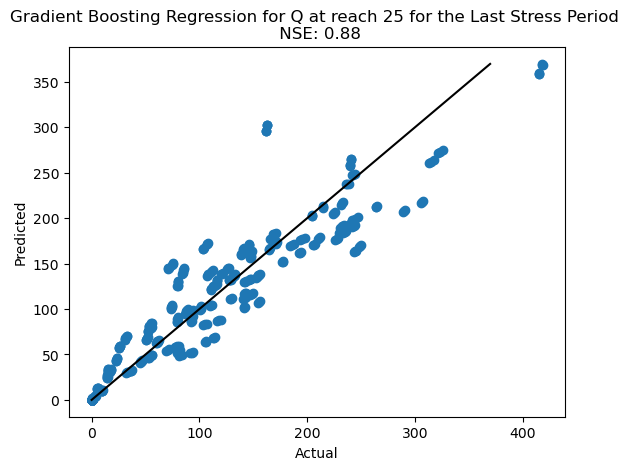

In [47]:
gr_imp_df.to_pickle('Seasons_GB_Impdf.pkl')


plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Gradient Boosting Regression for Q at reach " + str(rn) +" for the Last Stress Period \n NSE: " + str(round(np.median(NSEList),2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

1.0000000000000002
[    0     6    12 ... 12054 12060 12066]
Number of Features used in Stress period 0: 1895
Sum of Importances in Stress period 0: 0.09714836297232925
[    1     7    13 ... 12055 12061 12067]
Number of Features used in Stress period 1: 1895
Sum of Importances in Stress period 1: 0.15225671512916328
[    2     8    14 ... 12056 12062 12068]
Number of Features used in Stress period 2: 1895
Sum of Importances in Stress period 2: 0.05048165633380962
[    3     9    15 ... 12057 12063 12069]
Number of Features used in Stress period 3: 1895
Sum of Importances in Stress period 3: 0.2354049758025878
[    4    10    16 ... 12058 12064 12070]
Number of Features used in Stress period 4: 1918
Sum of Importances in Stress period 4: 0.3289953387027805
[    5    11    17 ... 12059 12065 12071]
Number of Features used in Stress period 5: 1918
Sum of Importances in Stress period 5: 0.13571295105932968


C:\Users\davem\AppData\Local\Temp\ipykernel_8540\1923263798.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


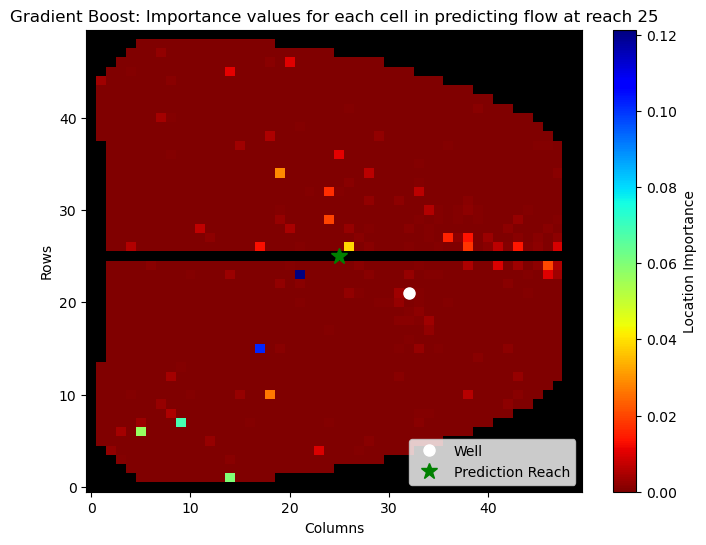

In [34]:
#importance_df = pd.DataFrame(importanceList_gr).sum()
#Testing out the feature importances - can pull it out by stress period but for some reason there's not an importance value for every feature...
#print(imp_df.sum(axis=1))
#usedFeatures = Tree.feature_names_in_.astype('int') #Get an array of features used in the decision tree as ints 
#feat_df = pd.DataFrame(Tree.feature_importances_, index = Tree.feature_names_in_.astype('int')) #make a dataframe of the feature importances with the index set to the feature name

gr_total_imp_df = gr_imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
print(gr_total_imp_df.sum())
#Sum up all the stress periods for each well location
gr_AllTSimp = gr_total_imp_df.groupby(gr_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

for i in range(numTS):
    featInTS = np.intersect1d(gr_total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(gr_total_imp_df.loc[featInTS].sum()))
    
#Should probably use this now - it tracks the well location number with the index
#well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])


#feature importance Mapping
wellmesh_gr = np.ndarray((50,50))
wellmesh_gr[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in gr_AllTSimp.index:
        wellmesh_gr[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = gr_AllTSimp.loc[k]
# for i in range(len(importance_df.index)):
#     #if(all_well_loc[i,1] != 25):
#     wellmesh[int(all_well_locNoRiv[i, 1]), int(all_well_locNoRiv[i, 0])] = importance_df.iloc[i] #np.sum(importanceList[:,i])  

#well_head_noRiv = well_head_df.drop(drop_locs2, axis = 1)
    
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(gr_AllTSimp)
#vmax = 0.1
vmin = np.min(gr_AllTSimp)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_gr,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Gradient Boost: Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")

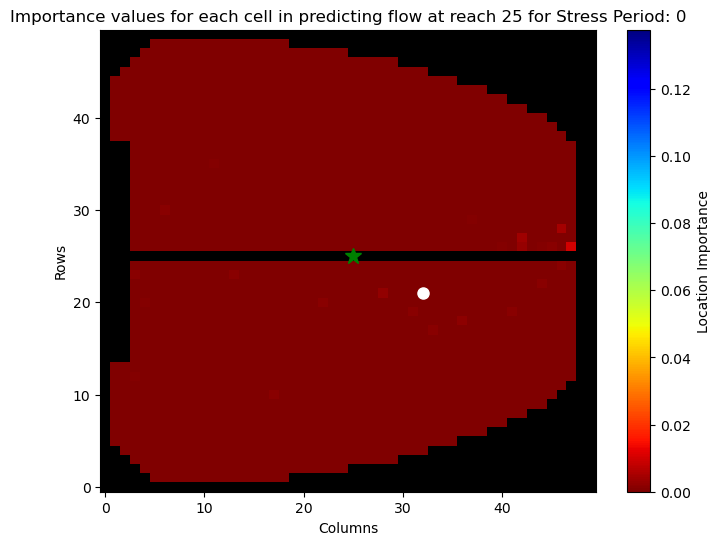

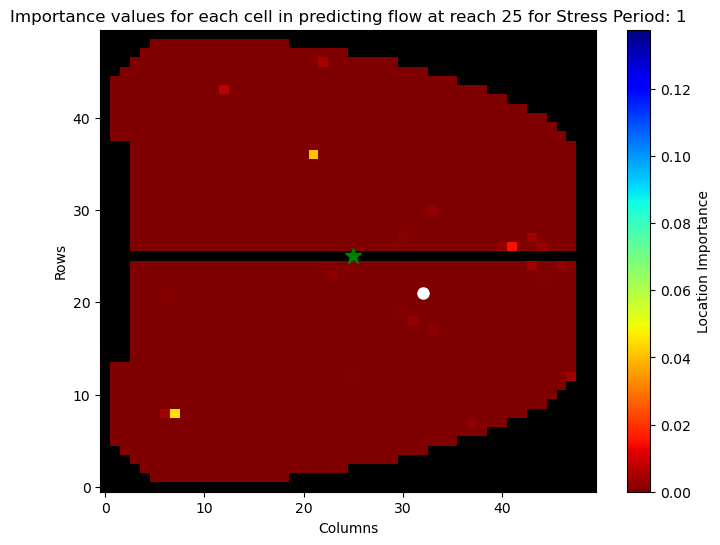

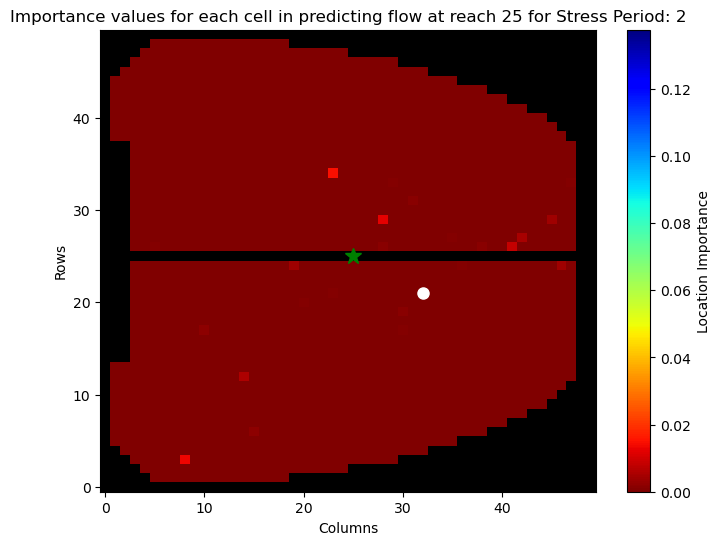

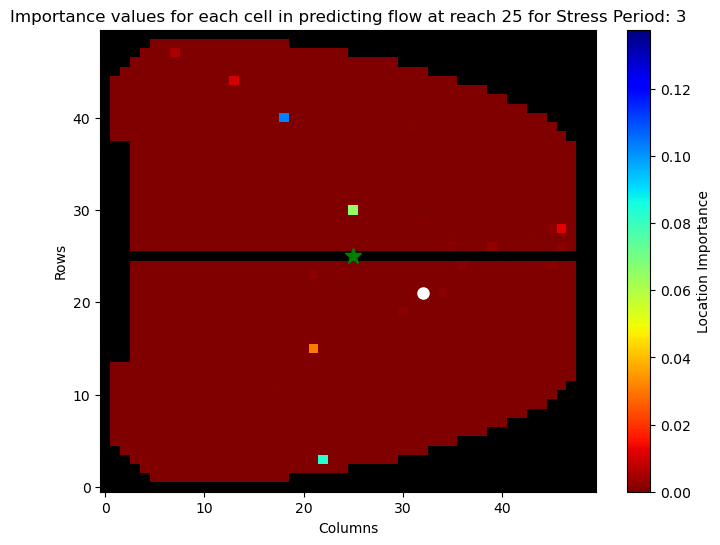

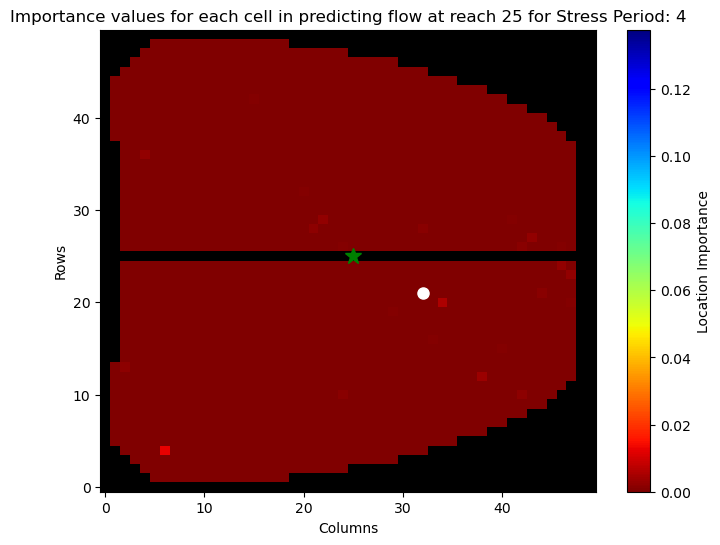

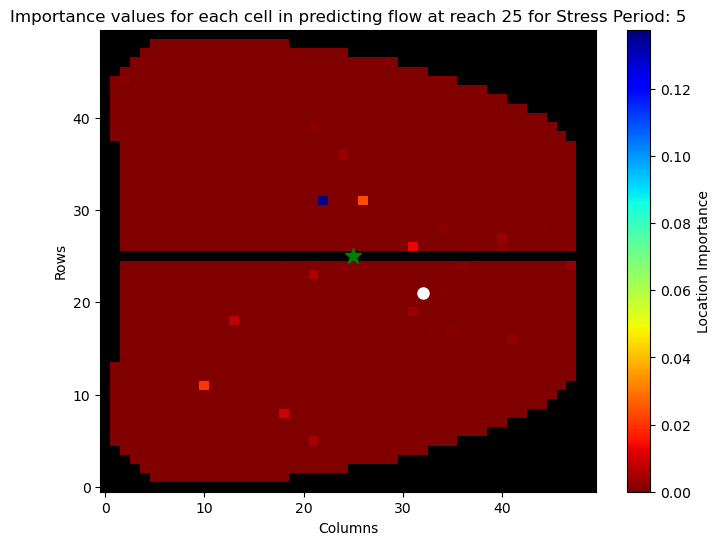

In [260]:
gr_wellmesh_AllTs = np.ndarray((numTS,50,50))
gr_wellmesh_AllTs[:,:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs, axis = 0)
#for i in range(all_well_loc.shape[0]):

#featInTS = np.intersect1d(usedFeatures, featIndices)
#pd.DataFrame(importanceArr[featInTS])#just going to use step period 0
for i in range(numTS):
    featInTS = np.intersect1d(gr_total_imp_df.index, TSIndices+i)    
    for k in featInTS:
        wellnum = k // numTS
        gr_wellmesh_AllTs[i,int(well_loc_df.loc[wellnum, 1]), int(well_loc_df.loc[wellnum, 0])] = gr_total_imp_df.loc[k] #np.sum(importanceList[:,i]) 
        
        
for i in range(numTS):
    plt.figure(figsize=(8,6))
    plt.pcolormesh(KK,GG,gr_wellmesh_AllTs[i],vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
    plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
    plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
    # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
    #plt.show()
    #plt.imshow(wellmesh, cmap='RdBu')
    plt.colorbar(label = "Location Importance")
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Importance values for each cell in predicting flow at reach ' + str(rn)+' for Stress Period: ' +str(i))


## Random Forest - Transient Seasons

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
RMSE:  24.26634801875127


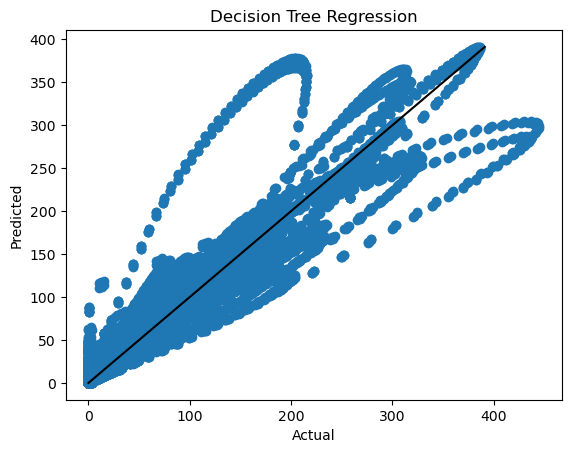

In [25]:
print(RandomForestRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 

#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2)
n_estimators = [int(x) for x in range(25,275,50)]
max_sample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
#splitter = ['best']
bootstrap = ['True']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
#max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                #'bootstrap' : bootstrap,
                'max_samples':max_sample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rfr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rfr_random.fit(X_train, y_train)
best_pars_rf = rfr_random.best_params_
print(best_pars_rf)

#from sklearn.tree import plot_tree


best_random_rf = rfr_random.best_estimator_
y_pred = best_random_rf.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

In [36]:
best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}

Average NSE:  0.8825702920955796
Total time: 595.0056555271149


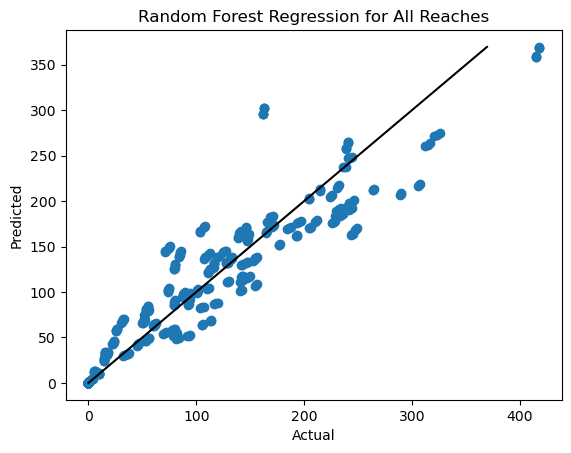

In [37]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
importanceListRF = []
depthlist = []

rf_imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

rn = 25

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
 
    RF = RandomForestRegressor(**best_pars_rf)
    
    RF = RF.fit(X_train,y_train)
    y_pred = RF.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))

    rf_feat_df = pd.DataFrame(RF.feature_importances_, index = RF.feature_names_in_.astype('int')) 
    rf_imp_df = rf_imp_df.merge(rf_feat_df.rename(columns={0:i}), left_index=True, right_index = True)
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.nanmean(NSEList))
#print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))



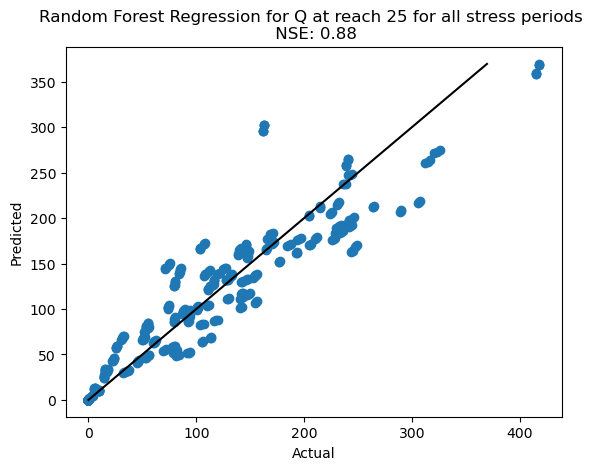

In [46]:
rf_imp_df.to_pickle('Seasons_RF_Impdf.pkl')


plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Random Forest Regression for Q at reach " + str(rn) +" for all stress periods \n NSE: " + str(round(np.median(NSEList),2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

1.0
[    0     6    12 ... 12054 12060 12066]
Number of Features used in Stress period 0: 1895
Sum of Importances in Stress period 0: 0.1873156733157327
[    1     7    13 ... 12055 12061 12067]
Number of Features used in Stress period 1: 1895
Sum of Importances in Stress period 1: 0.16044440251773387
[    2     8    14 ... 12056 12062 12068]
Number of Features used in Stress period 2: 1895
Sum of Importances in Stress period 2: 0.11356620573221196
[    3     9    15 ... 12057 12063 12069]
Number of Features used in Stress period 3: 1895
Sum of Importances in Stress period 3: 0.13136257727197126
[    4    10    16 ... 12058 12064 12070]
Number of Features used in Stress period 4: 1918
Sum of Importances in Stress period 4: 0.10684081037523059
[    5    11    17 ... 12059 12065 12071]
Number of Features used in Stress period 5: 1918
Sum of Importances in Stress period 5: 0.3004703307871196


C:\Users\davem\AppData\Local\Temp\ipykernel_8540\4001706885.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


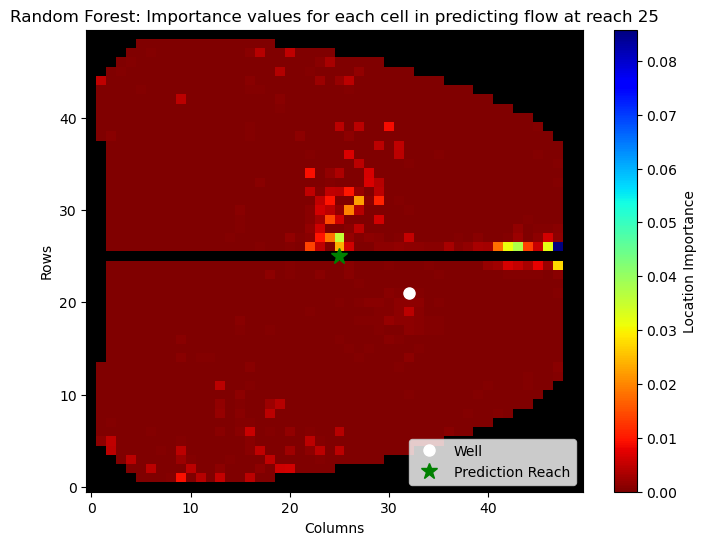

In [40]:
rf_total_imp_df = rf_imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
print(rf_total_imp_df.sum())
#Sum up all the stress periods for each well location
rf_AllTSimp = rf_total_imp_df.groupby(rf_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

for i in range(numTS):
    featInTS = np.intersect1d(rf_total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(rf_total_imp_df.loc[featInTS].sum()))
    
#feature importance Mapping
wellmesh_rf = np.ndarray((50,50))
wellmesh_rf[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in rf_AllTSimp.index:
        wellmesh_rf[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = rf_AllTSimp.loc[k]


cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(rf_AllTSimp)
#vmax = 0.1
vmin = np.min(rf_AllTSimp)
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_rf,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Random Forest: Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")


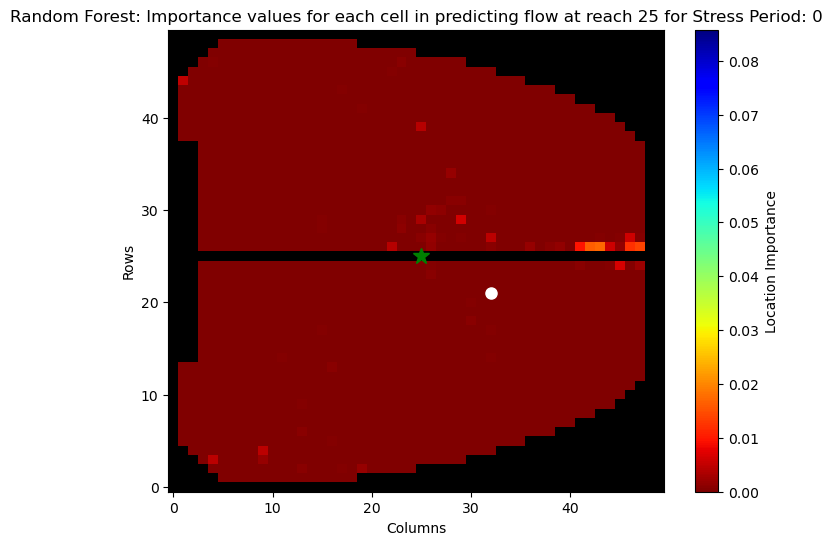

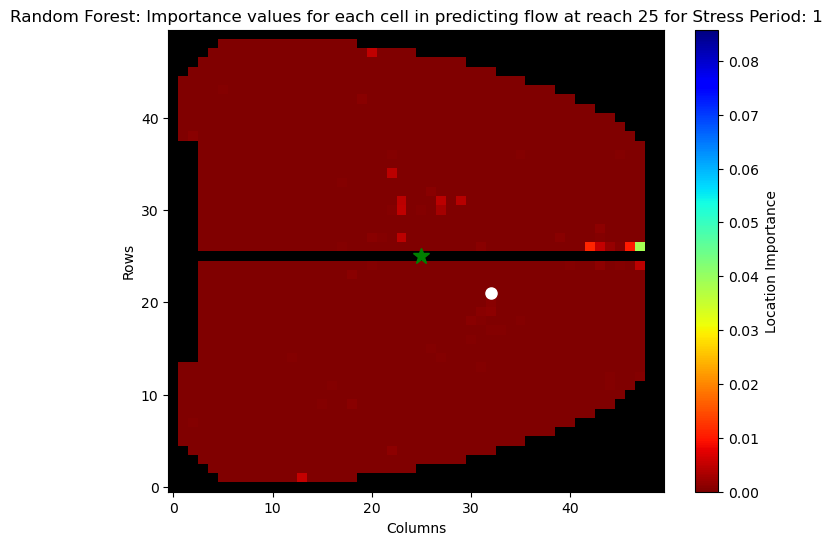

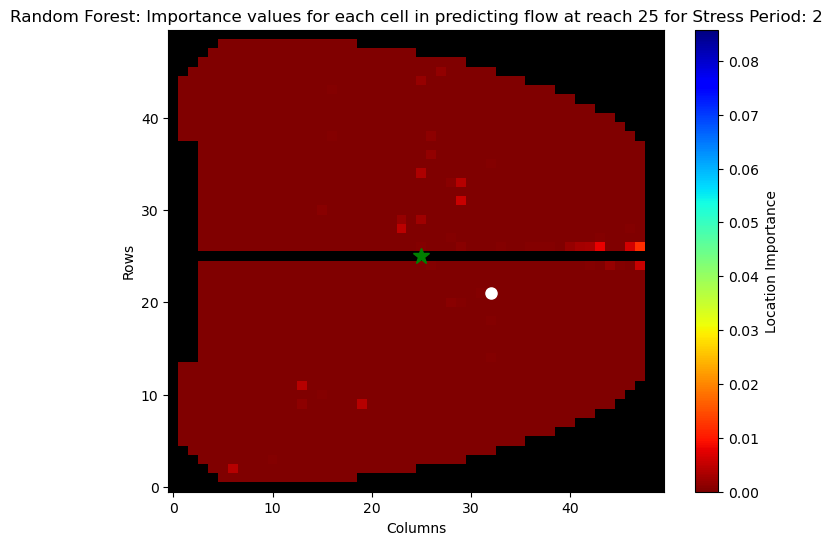

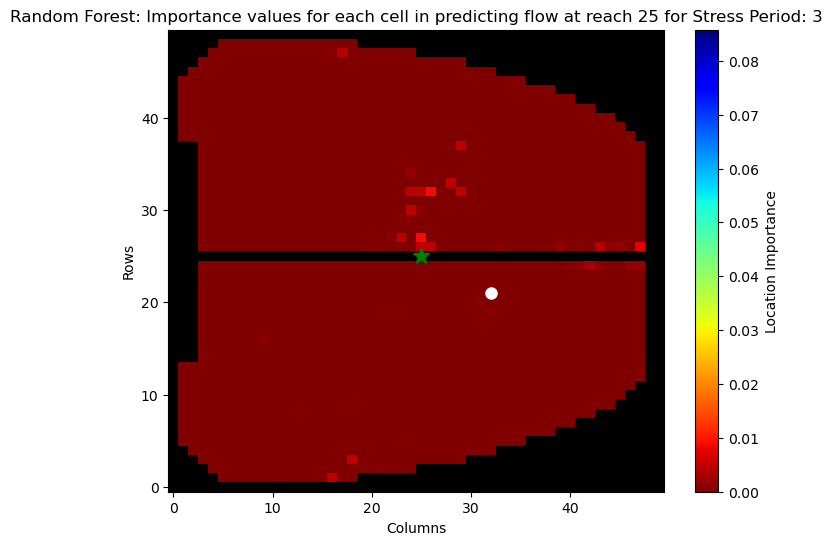

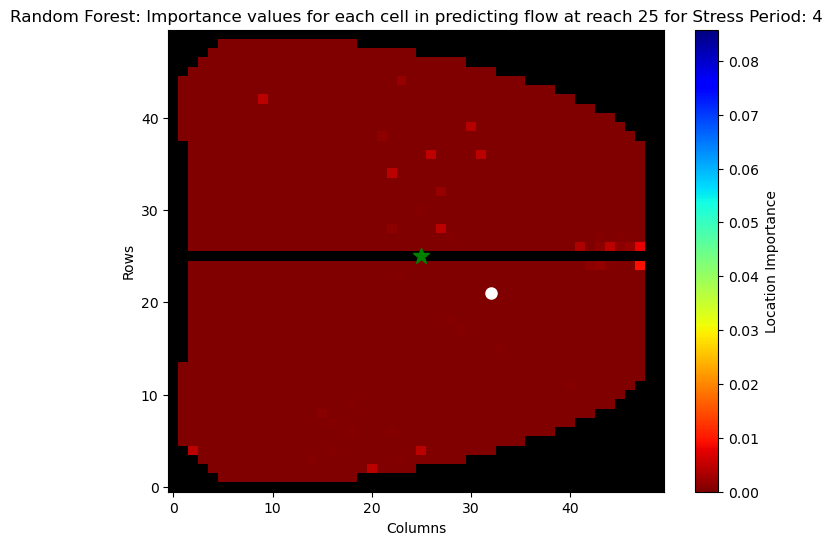

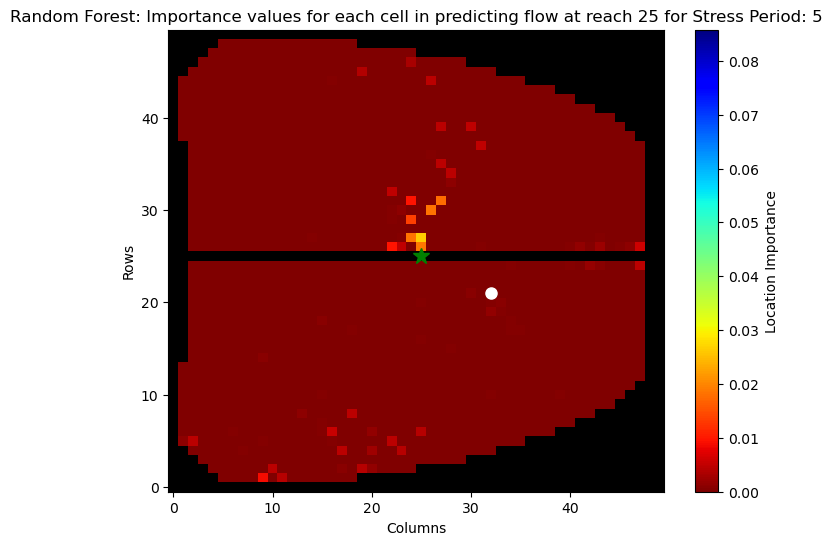

In [41]:
rf_wellmesh_AllTs = np.ndarray((numTS,50,50))
rf_wellmesh_AllTs[:,:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs, axis = 0)
#for i in range(all_well_loc.shape[0]):

#featInTS = np.intersect1d(usedFeatures, featIndices)
#pd.DataFrame(importanceArr[featInTS])#just going to use step period 0
for i in range(numTS):
    featInTS = np.intersect1d(rf_total_imp_df.index, TSIndices+i)    
    for k in featInTS:
        wellnum = k // numTS
        rf_wellmesh_AllTs[i,int(well_loc_df.loc[wellnum, 1]), int(well_loc_df.loc[wellnum, 0])] = rf_total_imp_df.loc[k] #np.sum(importanceList[:,i]) 
        
        
for i in range(numTS):
    plt.figure(figsize=(8,6))
    plt.pcolormesh(KK,GG,rf_wellmesh_AllTs[i],vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
    plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
    plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
    # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
    #plt.show()
    #plt.imshow(wellmesh, cmap='RdBu')
    plt.colorbar(label = "Location Importance")
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Random Forest: Importance values for each cell in predicting flow at reach ' + str(rn)+' for Stress Period: ' +str(i))


[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.96419839 0.98651288 0.95561707 1.        ]
 [0.95976932 0.98479047 0.95044983 1.        ]
 ...
 [0.03137255 0.2044752  0.44372165 1.        ]
 [0.03137255 0.19635525 0.43166474 1.        ]
 [0.03137255 0.18823529 0.41960784 1.        ]]


C:\Users\davem\AppData\Local\Temp\ipykernel_8540\2005833687.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)


[Text(0.0, 0, ''),
 Text(0.15, 0, 'Random Forest'),
 Text(0.5, 0, 'Gradient Boosted'),
 Text(0.85, 0, 'Decision Tree'),
 Text(1.0, 0, '')]

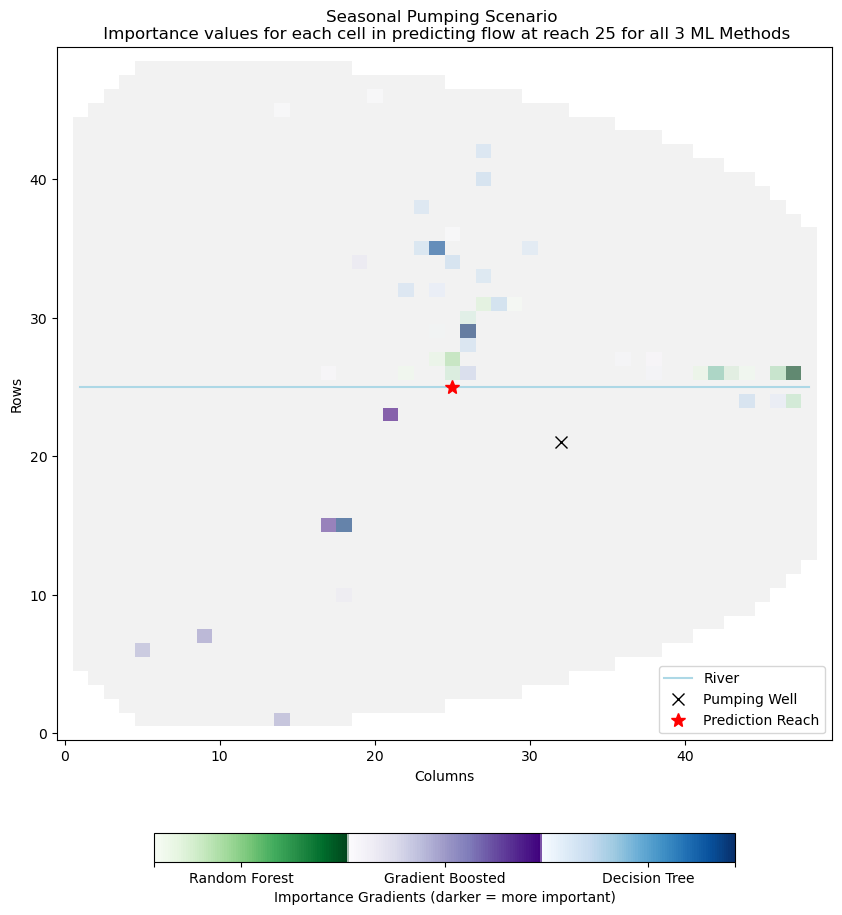

In [45]:
river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.01)
vmaxrf = np.max(wellmesh_rf)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_gr, wellmesh_gr < 0.01)
vmaxgr = np.max(wellmesh_gr)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_dt, wellmesh_dt < 0.01)
vmaxdt = np.max(wellmesh_dt)

vmin = 0.01
# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128))))
print(colors)

mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = vmax, vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmaxdt, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmaxrf, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmaxgr, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Seasonal Pumping Scenario \n Importance values for each cell in predicting flow at reach ' + str(rn) + ' for all 3 ML Methods')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.15,0.5,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Random Forest', 'Gradient Boosting','Decision Tree',''])
#plt.legend()